<a href="https://colab.research.google.com/github/luigiselmi/python_hpc/blob/main/ch7/diffusion_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation using PyTorch
We use a PyTorch tensor to store the grid and compute the output of the diffusione equation at the grid points.
We write again the diffusion equation

$$ \frac{\partial u(x, t)}{\partial t} = D \nabla^2 u(x, t)$$

where D is the diffusion coefficient and $\nabla^2$ is the Laplacian operator.

In [1]:
import time
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import roll, zeros

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GRID_SHAPE = (2048, 2048)

In [4]:
!nvidia-smi

Tue Sep 16 15:33:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
def timer(fxn, max_time=5):
    N = 0
    total_time = 0
    fxn()  # prime the pump
    while total_time < max_time:
        start = time.perf_counter()
        fxn()
        total_time += time.perf_counter() - start
        N += 1
    return total_time / N

In [6]:
def init_grid(grid_shape):
    grid = zeros(grid_shape)
    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    grid[block_low:block_high, block_low:block_high] = 0.005
    return grid

In [7]:
def laplacian(grid):
    return (
        roll(grid, +1, 0) +
        roll(grid, -1, 0) +
        roll(grid, +1, 1) +
        roll(grid, -1, 1) -
        4 * grid
    )

In [8]:
def evolve(grid, dt, D=1):
    return grid + dt * D * laplacian(grid)

In [49]:
def run_experiment(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)
    for i in range(num_iterations):
        grid = evolve(grid, 0.1) # local computation on cpu
    exec_time = time.time() - start_time
    return grid, exec_time

In [52]:
def debug_cpu_onboard(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)
    grid = grid.to(device)  # sends the grid to the gpu for computation if available
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
        torch.cuda.synchronize() # ?
    exec_time = time.time() - start_time
    return grid, exec_time

In [53]:
def debug_cpu_copy(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)
    grid = grid.to(device)  # <3>
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
        grid.cpu() # send a copy to the cpu
    exec_time = time.time() - start_time
    return grid, exec_time

If we use the GPU we have to copy the tensor to host memory first like in example 2.

In [ ]:
if __name__ == "__main__":
    grid_shape = (4096, 4096)
    num_iterations = 1000
    diffuse_grid_cpu, exec_time = run_experiment(num_iterations, grid_shape=grid_shape)
    print('1. Execution time: {:.2f} sec.'.format(exec_time))
    diffuse_grid, exec_time = debug_cpu_onboard(num_iterations, grid_shape=grid_shape)
    print('2. Execution time: {:.2f} sec.'.format(exec_time))
    diffuse_grid_gpu, exec_time = debug_cpu_copy(num_iterations, grid_shape=grid_shape)
    print('3. Execution time: {:.2f} sec.'.format(exec_time))

In [20]:
diffuse_grid_cpu_copy = diffuse_grid.cpu()

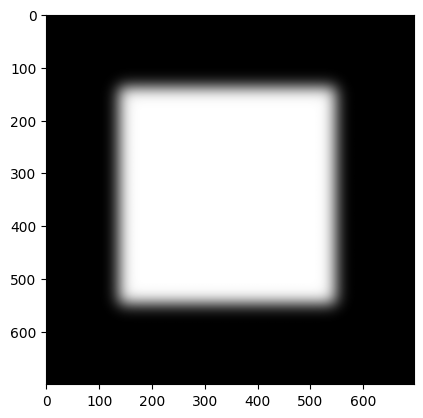

In [45]:
plt.imshow(diffuse_grid_cpu_copy[1500:2200, 1500:-1900], cmap='gray')

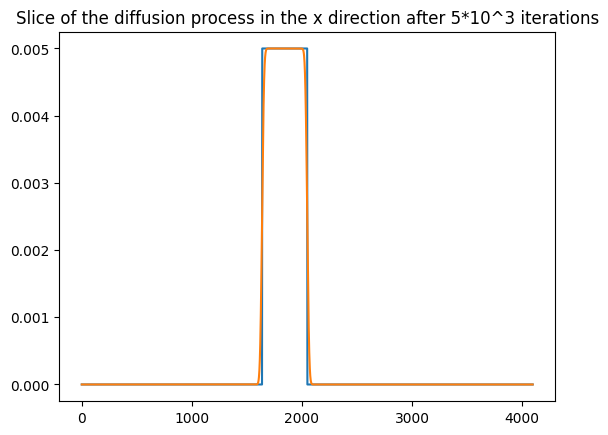

In [47]:
grid = init_grid(grid_shape)
diffuse_grid_x = diffuse_grid_cpu_copy[1800,:]
x = torch.arange(0, diffuse_grid_x.shape[0])
plt.title('Slice of the diffusion process in the x direction after 5*10^3 iterations')
plt.plot(x, grid[1800,:])
plt.plot(x, diffuse_grid_x)